In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from LinearStage import LinearStage
from PowerMeter import PowerMeter

from scipy.optimize import curve_fit

In [2]:
# Linear Stage Initialization and Connection
ls = LinearStage()
lls = ls.find_devices()
print(lls)
info = ls.connect(lls[0])
print(info)

# Power Meter Initialization and Connection
# Setting Background
pm = PowerMeter()
lpm = pm.find_powermeter()
print(lpm)
pm.connect(lpm[0])

pm.read(printval=True)
pm.get_background()
pm.read(printval=True)

['/dev/cu.usbserial-DK0IVUTB']
Status is a dictionary.
/dev/cu.usbserial-DK0IVUTB, address 0: ELL17 	(S/N: 11700020)
Status is a dictionary.
Status OK (position)
{'Address': '0', 'Motor Type': 17, 'Serial No.': '11700020', 'Year': '2025', 'Firmware': '14', 'Thread': None, 'Hardware': '1', 'Range': 28, 'Pulse/Rev': 1024}
['Thorlabs,PM100D,P0023223,2.6.0\n']
Wavelength: 4.000000E+02 nm
Connected to powermeter: Thorlabs,PM100D,P0023223,2.6.0

Measure: 0.00155604526 W
Background: 0.00155586505 W
Measure: -4.49399999999725e-08 W


-4.49399999999725e-08

In [ ]:
start = 23
end = 28
step = 0.2

ls.jog_and_measure(start=start, end=end, step=step, function=pm.read, time_wait=0.5)


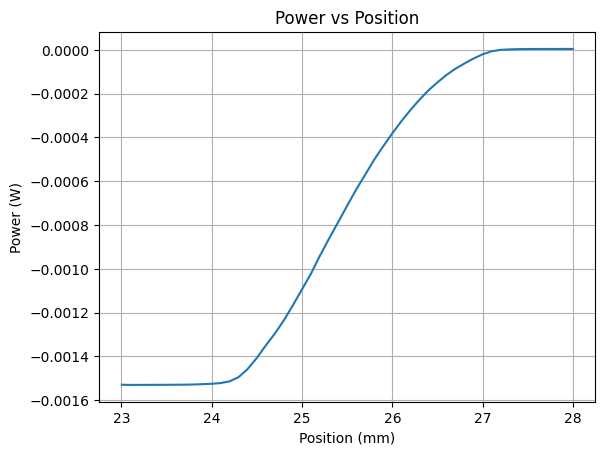

In [43]:
data1 = np.loadtxt("step_0.1_1.txt", skiprows=1)
data2 = np.loadtxt("step_0.1_2.txt", skiprows=1)

data3 = np.loadtxt("step_0.2_1.txt", skiprows=1)
plt.plot(data1[:, 0], data1[:, 1])

plt.title("Power vs Position")
plt.xlabel("Position (mm)")
plt.ylabel("Power (W)")
plt.grid()

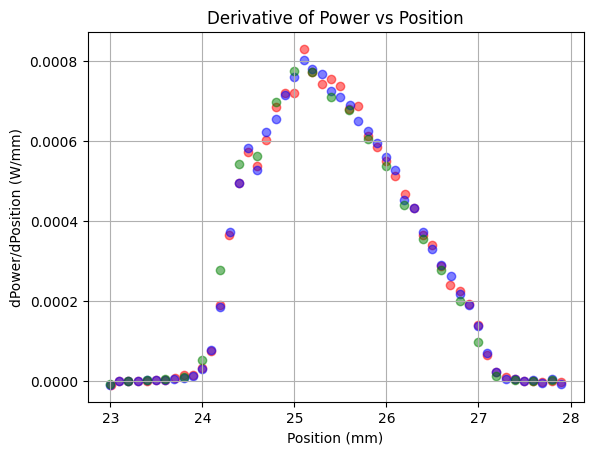

In [ ]:
# differentiate the data
diff = np.diff(data1[:, 1]) / np.diff(data1[:, 0])
diff2 = np.diff(data2[:, 1]) / np.diff(data2[:, 0])
diff3 = np.diff(data3[:, 1]) / np.diff(data3[:, 0])

x_diff = data1[:-1, 0]
x_diff2 = data2[:-1, 0]
x_diff3 = data3[:-1, 0]

plt.scatter(x_diff, diff, label='Derivative', color='red', alpha=0.5)
plt.scatter(x_diff2, diff2, label='Derivative 2', color='blue', alpha=0.5)
plt.scatter(x_diff3, diff3, label='Derivative 3', color='green', alpha=0.5)
plt.title("Derivative of Power vs Position")
plt.xlabel("Position (mm)")
plt.ylabel("dPower/dPosition (W/mm)")
plt.grid()

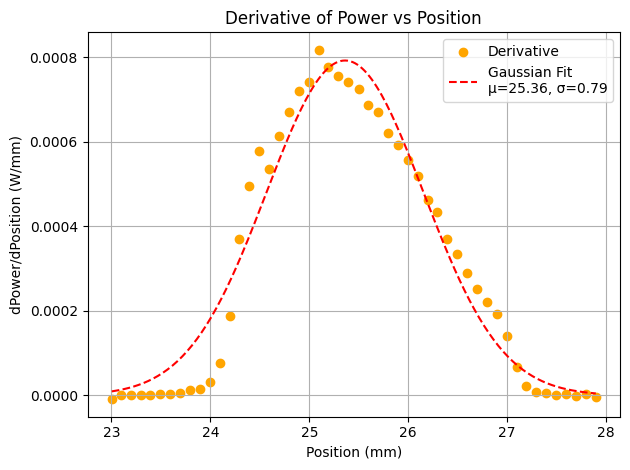

In [41]:
# Define Gaussian function
def gaussian(x, amp, mean, stddev):
    return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# Initial parameter guesses
amp_guess = np.max(diff)  # Amplitude guess: max of derivative
mean_guess = x_diff[np.argmax(diff)]  # Mean guess: position at max derivative
stddev_guess = (x_diff[-1] - x_diff[0]) / 6  # Stddev guess: ~1/6 of x range

# Fit Gaussian
p0 = [amp_guess, mean_guess, stddev_guess]
popt, pcov = curve_fit(gaussian, x_diff, diff, p0=p0)
amp, mean, stddev = popt

# Generate points for fitted Gaussian
x_fit = np.linspace(min(x_diff), max(x_diff), 200)
y_fit = gaussian(x_fit, *popt)

plt.scatter(x_diff, diff, label='Derivative', color='orange')
plt.plot(x_fit, y_fit, 'r--', label=f'Gaussian Fit\nμ={mean:.2f}, σ={stddev:.2f}')
plt.title("Derivative of Power vs Position")
plt.xlabel("Position (mm)")
plt.ylabel("dPower/dPosition (W/mm)")
plt.legend()
plt.grid()

print(f"Fitted Gaussian Parameters:")
print(f"Amplitude: {amp:.4f} W/mm")
print(f"Mean: {mean:.4f} mm")
print(f"Standard Deviation: {stddev:.4f} mm")

plt.tight_layout()
plt.show()